In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

from apyori import apriori

import datetime

import statsmodels.api as sm

from scipy.stats import spearmanr 

from sklearn.impute import SimpleImputer

from scipy.spatial.distance import cdist 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

import joblib
from sklearn.metrics import r2_score 

from math import radians, cos, sin, asin, sqrt

imp_df = pd.read_csv('./dataset_w_weather&rwi.csv')
imp_df.head(5)

,Date,Time,Race,Gender,Body_Size,Age_Range,With_Kids,Kids_Category,Basket_Size,Basket_colour,...,buyDrinks,TotalSpent_RM,latitude,longitude,Num_of_Baskets,weather,Day,Month,Year,rwi
0,19/10/2015,Evening,malay,male,moderate,28.0,yes,young,big,red,...,2.0,9.0,2.912316,101.657948,1.0,Clear,Monday,October,2015,0.912
1,19/10/2015,Evening,malay,female,moderate,30.0,no,no_kids,big,blue,...,2.0,13.0,2.935533,101.737170,1.0,Clear,Monday,October,2015,0.817
2,19/10/2015,Evening,indian,male,thin,51.0,no,no_kids,small,black,...,2.0,16.0,2.949924,101.637069,1.0,Clear,Monday,October,2015,0.653
3,19/10/2015,Evening,indian,male,moderate,34.0,no,no_kids,big,blue,...,1.0,13.0,2.903530,101.661249,3.0,Clear,Monday,October,2015,0.912
4,20/10/2015,Night,indian,male,thin,49.0,no,no_kids,big,blue,...,0.0,16.0,2.951176,101.746526,3.0,Clear,Tuesday,October,2015,0.845


In [2]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))
  
imp_df = imp_df.apply(LabelEncoder().fit_transform)

X = imp_df.drop(['Basket_Size'], axis=1)
y = imp_df['Basket_Size']

rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state=1)

feat_selector.fit(X.values, y.values.ravel())

boruta_score = ranking(list(map(float, feat_selector.ranking_)), X.columns, order=-1)
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score", ascending = False)

print('---------Top 10----------')
display(boruta_score.head(10))

print('---------Bottom 10----------')
display(boruta_score.tail(10))

---------Top 10----------


,Features,Score
28,rwi,1.00
21,latitude,1.00
26,Month,1.00
24,weather,1.00
22,longitude,1.00
0,Date,0.96
27,Year,0.92
5,Age_Range,0.87
18,TimeSpent_minutes,0.83
9,Attire,0.79


---------Bottom 10----------


,Features,Score
17,Spectacles,0.42
16,Dryer_No,0.29
1,Time,0.29
2,Race,0.29
4,Body_Size,0.21
23,Num_of_Baskets,0.17
11,shirt_type,0.12
13,pants_type,0.08
14,Wash_Item,0.08
3,Gender,0.00


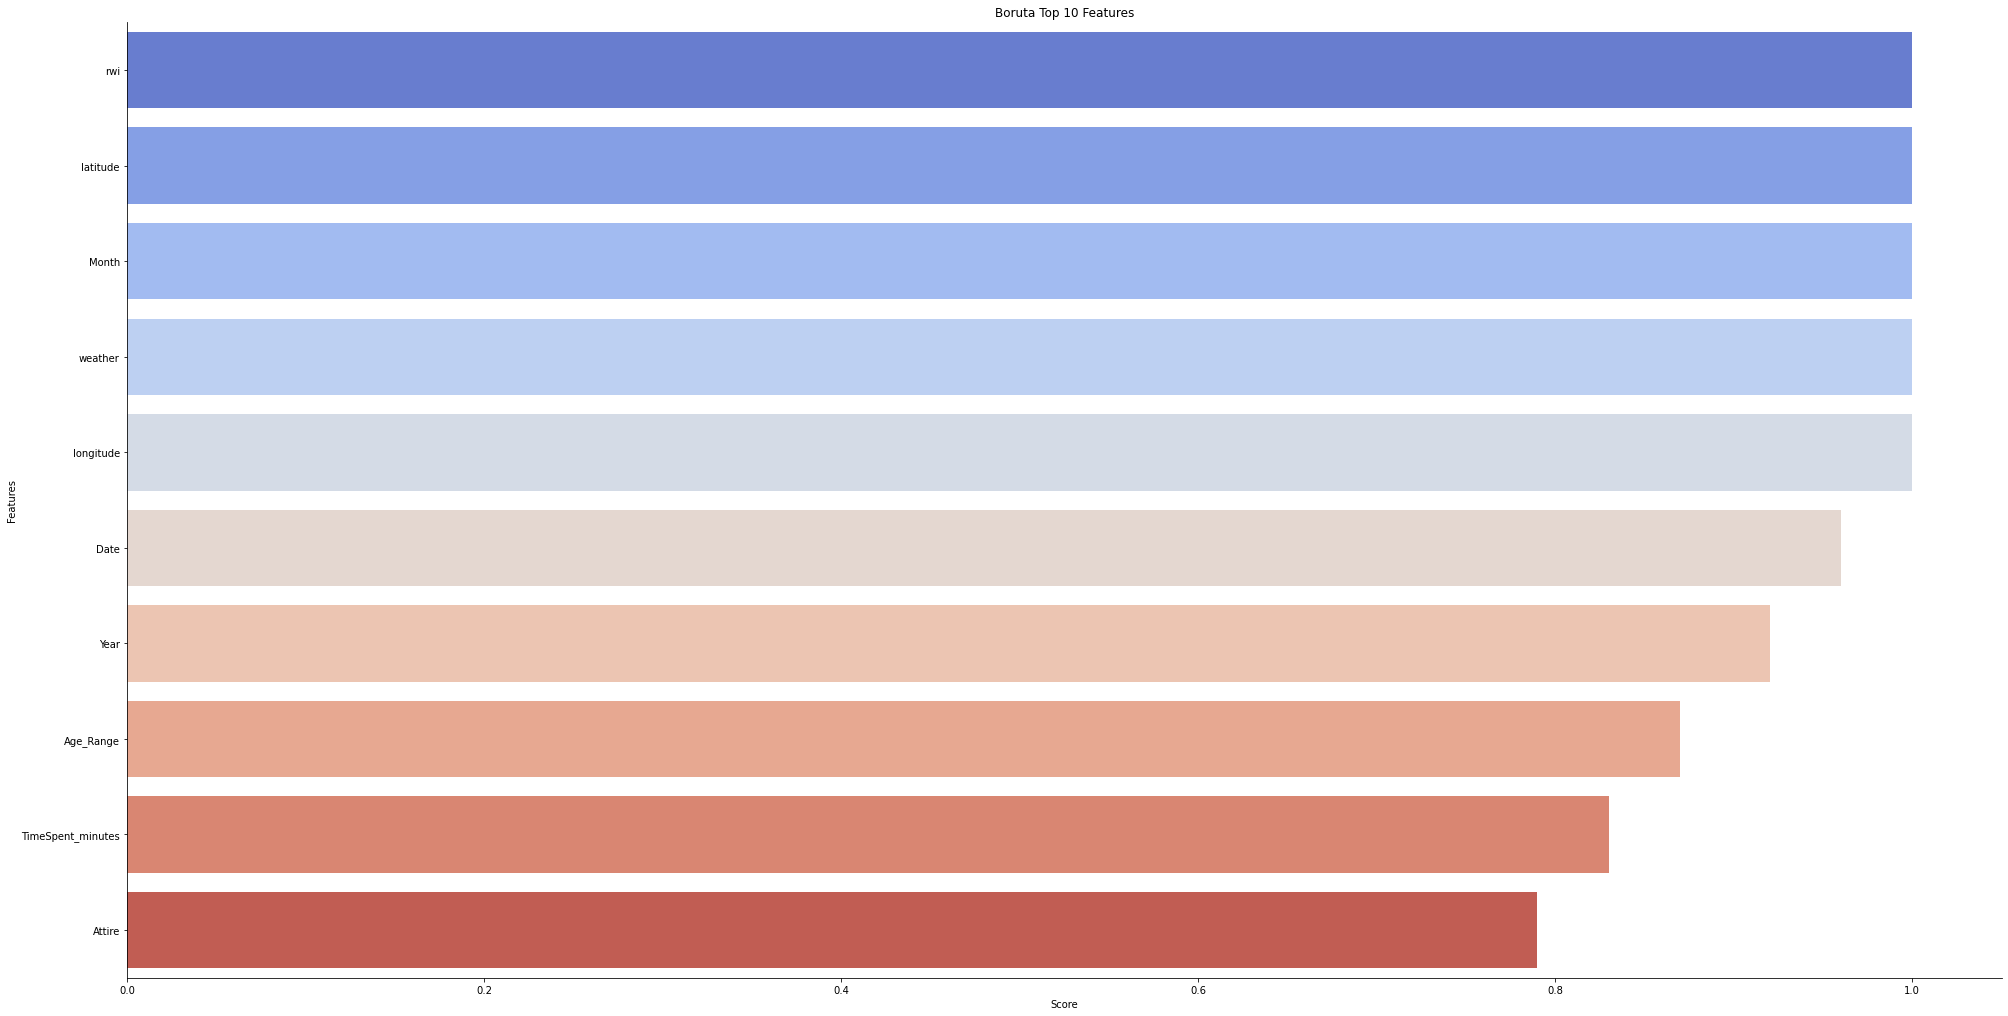

In [3]:
sns_boruta_plot = sns.catplot(x="Score", y="Features", data = boruta_score[:10], kind = "bar", height=14, aspect=2, palette='coolwarm')
plt.title("Boruta Top 10 Features")
sns_boruta_plot.figure.savefig('DT_BS_Boruta.png')

In [4]:
rtX = imp_df[['rwi', 'latitude', 'Month', 'weather', "longitude", "Year", "Age_Range", "TimeSpent_minutes", "Attire"]]
# one hot encoding
rtX = pd.get_dummies(rtX, columns=["Month", "weather", "longitude"  , "Year", "Attire"])

rtY = imp_df[['rwi']]

rtx_train, rtx_test, rty_train, rty_test = train_test_split(rtX, rtY, test_size=0.4, random_state=1)

print(rtx_train.shape)
print(rtx_test.shape)

# create decision tree regressor object
regressor = DecisionTreeRegressor(random_state=0)

# fit regressor with bX and Y data
regressor.fit(rtx_train, rty_train)

# score model
score = regressor.score(rtx_test, rty_test)
print(score)

# make predictions
expected = rty_test
predicted = regressor.predict(rtx_test)

print("R2-score: %.2f" % r2_score(predicted , expected) )

(2188, 3670)
(1460, 3670)
0.9999830331040191
R2-score: 1.00
